# Action Grammars: A Grammar-Induction Based Method for Learning Temporally-Extended Actions
## Authors: Robert Lange and Aldo Faisal | January 2019

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import numpy as np

import gym
import gym_hanoi

In [32]:
from agents import Agent_Q, SMDP_Agent_Q, Macro, SMDPQTable
from utils.q_learning import  q_learning
from utils.learning_params import *
from utils.general import *
from utils.plotting import *

In [7]:
# Create directory - Learning performance
results_dir = os.getcwd() + "/results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print("Created New Results Directory")

# Create directory - Log directory
log_dir = os.getcwd() + "/logs/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
    
# Create directory - Figure directory
fig_dir = os.getcwd() + "/figures/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Fig Directory")

# Towers of Hanoi - Setup

In [8]:
num_episodes = 500
max_steps = 500

log_freq = 10  # greedily evaluate policy after amount of episodes
log_episodes = 100
learning_times = 5

verbose = True

N = 4

alpha, gamma, lambd, epsilon = learning_parameters(l_type="Q-Learning")

### Simple TD($\lambda$) Learning

In [9]:
env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0)

agent = Agent_Q(env)

/Users/rtl/anaconda2/envs/AG/lib/python3.6/site-packages/gym-0.10.9-py3.6.egg/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Hanoi Environment Parameters have been set to:
	 Number of Disks: 4
	 Transition Failure Probability: 0


In [11]:
hist, er_buffer = q_learning(env, agent, num_episodes, max_steps,
                             gamma, alpha, lambd, log_freq, log_episodes, verbose)

Ep:  1 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 11 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 21 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 31 | Avg/Std Steps: 19.00/0.00 | Avg/Std Ret: 39.72/0.00 | Success R: 1.00
Ep: 41 | Avg/Std Steps: 21.00/0.00 | Avg/Std Ret: 35.85/0.00 | Success R: 1.00
Ep: 51 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 61 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 71 | Avg/Std Steps: 16.00/0.00 | Avg/Std Ret: 46.33/0.00 | Success R: 1.00
Ep: 81 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 91 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 101 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 111 | Avg/Std Steps: 16.00/0.00 | Avg/Std Ret: 46.33/0.00 | Success R: 1.00
Ep: 121 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret

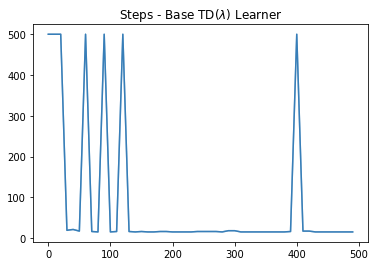

In [12]:
plot_learning(hist[:, 0], hist[:, 1], hist[:,2], title=r"Steps - Base TD($\lambda$) Learner")

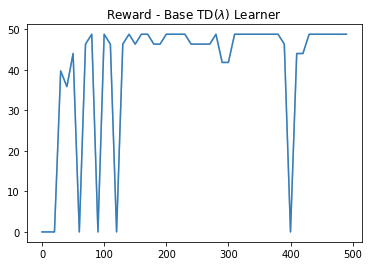

In [13]:
plot_learning(hist[:, 0], hist[:, 3], hist[:, 4], title=r"Reward - Base TD($\lambda$) Learner")

### SMDP-Q-Learning

In [14]:
seq_macros = {4: ["abd"],
              5: ["bafbcd", "baf", "ec", "bc"],
              6: ["abdaef", "abdced", "abdaef", "aedce",
                  "abdce", "abd", "ae", "ce"], 
              7: ["bafbcdbafecfbafbcdbcfecd", "bafbcdbafecf",
                  "bafecdbcfecbafbcdbcfec", "bafbcdbafec",
                  "bcfecbafbcec"]}

In [15]:
N = 5
env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0)

macros = []
for i in range(len(seq_macros[N])):
    macros.append(Macro(env, seq_macros[N][i]))

Hanoi Environment Parameters have been set to:
	 Number of Disks: 5
	 Transition Failure Probability: 0


In [33]:
Q = SMDPQTable(env.get_movability_map(), macros)

In [32]:
agent = SMDP_Agent_Q(env, Q, macros)

In [ ]:
log_template = "Ep: {:>2} | Avg/Std Steps: {:.2f}/{:.2f} | Avg/Std Ret: {:.2f}/{:.2f} | Success R: {:.2f}"
log_counter = 0
hist = np.zeros((int(num_episodes/log_freq), 6))

# Init Replay Buffer
er_buffer = ReplayBuffer(num_episodes*max_steps)

for ep_id in range(num_episodes):

    cur_state = env.reset()

    stp = 0
    tot_td = 0
    rewards = []

    eligibility = np.zeros(agent.q_func.table.shape)

    old_greedy_choice = None
    old_action = None
    old_state = None

    for i in range(max_steps):
        action = agent.epsilon_greedy_action(cur_state)
        next_state, reward, done, _ = env.step(action)
        greedy_choice = agent.greedy_action(next_state)

        # Update value function
        eligibility, tde = q_learning_update(gamma, alpha, lambd, agent.q_func,
                                             eligibility, cur_state, action,
                                             next_state, reward, done, stp,
                                             old_greedy_choice, old_action, old_state)

        # Extend replay buffer
        er_buffer.push(ep_id, old_state, action, reward, next_state, done)

        # Update variables
        old_state = cur_state
        old_action = action
        old_greedy_choice = greedy_choice
        cur_state = next_state

        # Update counters
        stp += 1
        tot_td += tde
        rewards.append(reward)

        # Go to next episode if successfully ended
        if done:
            break

    if ep_id % log_freq == 0:
        avg_steps, sd_steps, avg_ret, sd_ret, success_rate = greedy_eval(env, agent, gamma,
                                                                         max_steps, log_episodes)
        hist[log_counter,:] = np.array([ep_id, avg_steps, sd_steps,
                                        avg_ret, sd_ret, success_rate])
        log_counter += 1

        if verbose:
            print(log_template.format(ep_id + 1, avg_steps, sd_steps,
                                      avg_ret, sd_steps, success_rate))